In [1]:
import pickle
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import scipy
import numpy as np

### Loading Model

In [2]:
model_a = pickle.load(open("../model/selected_model.pkl","rb"))

### Loading Data

In [3]:
x_train, _, y_true_a, _ = pickle.load(open("../tmp/selected_features/selected_features_data.pkl", "rb"))["data"]

### Model A Predictions

In [4]:
y_predictions_a = model_a.predict(x_train)

Text(0, 0.5, 'density')

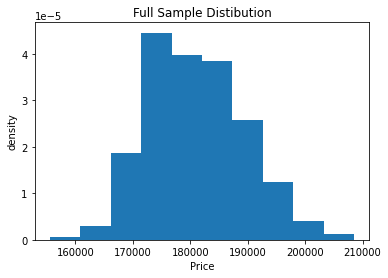

In [5]:
plt.hist(y_predictions_a,density=True)
plt.title("Full Sample Distibution")
plt.xlabel("Price")
plt.ylabel("density")

In [6]:
y_true_a.shape

(978,)

### Defining Model B

In [7]:
 x_train_b, _, y_true_b, _ = sklearn.model_selection.train_test_split(x_train, y_true_a, test_size=0.5, random_state=42)

In [8]:
y_true_b.shape

(489,)

In [9]:
y_predictions_b = model_a.predict(x_train_b)

Text(0, 0.5, 'density')

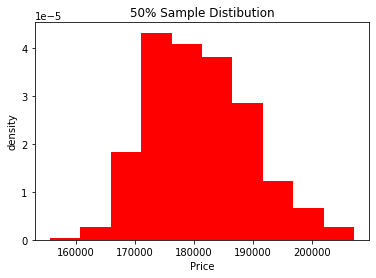

In [10]:
plt.hist(y_predictions_b,density=True,color ="r")
plt.title("50% Sample Distibution")
plt.xlabel("Price")
plt.ylabel("density")

In [11]:
def model_b(samples,size=489):
    val = np.random.choice(samples,replace = True, size = size)
    return val

## Experiment

The experiment consists in comparing the two models' performance. Model A is a machine learning trained model and Model B is a random draw from the distribution from 50% of the predictions made by the machine learning model. A good model will not deviate more than 10,000 USD from the true price.

Let the prediction of model A be defined as $f(X_i)=\hat y_i$ and the true value $y_i$ where $i \in N=\{(X_1,y_1),(X_2,y_2)...(X_n,y_n)\}$ and $X_i$ is a vector of features.

Model B is described as follows:

Let $M \subset N$. M is randomly selected and $\#(M)=\frac{\#(N)}{2}$

Let $W$ be a random variable from $f(x_m)$ from a random draw of $x_m \in M$. 


We asume that a prediction within a +- 10,000 difference from its true value is considered a good prediction. To test which model is better we will caculate the proportions for each model and design a statistical test to determine if they are the same or if greater than the other. To do that we will use bootstap methods. 

For model B, we will simulate a sample of random $W$ as $\{W_1,W_2...W_M\}$ for our sample distribution and then calculate $g^b_i = 1 \text{ if }  W - y_m\leq 10000, 0 \text{ othewise } $.
For Model A we will do the following $g^a_i = 1 \text{ if }  W - y_m\leq 10000, 0 \text{ othewise } $.


Now from the set of $\mathbf g^a$ and $\mathbf g^b$ we will resample with replacement of the same size as their original set (978 and 498) and then calculate $T(\mathbf g)$ where 
$T(\mathbf g)= \frac{\sum^K_j g_j}{K^q}$ where $K^q$ is the number of elements in sets $\mathbf g^a$ and $\mathbf g^b$ (Note $q\in{a,b}$)

We will simulate this 10,000 times to get distributions of  $\mathbf g^a$ and $\mathbf g^b$, which would indicate distribution of porportion statistic for good predictions.


If the confidence intervals do not overlap at all, we can assure both statistics are different and we could assume that the one centered further to the right will be better.

### Bootstraping distribution from model A

In [12]:
def bootstrap_mean_a(y_predictions_a,y_true_a):
    sample = abs(y_predictions_a-y_true_a)
    sample[sample<10000]=1
    sample[sample>=10000]=0
    boot_sample_means = []
    for i in range(10000):
        boot_sample = np.random.choice(sample,replace = True, size = sample.shape[0])
        boot_sample_means.append(np.mean(boot_sample))

    return boot_sample_means

In [13]:
mean_prop_dist_a = bootstrap_mean_a(y_predictions_a,y_true_a)

Text(0, 0.5, 'density')

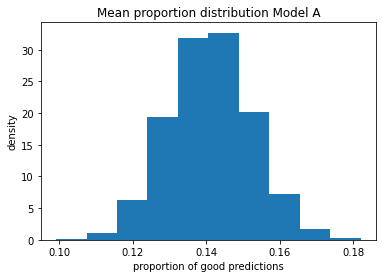

In [14]:
plt.hist(mean_prop_dist_a,density=True)
plt.title("Mean proportion distribution Model A")
plt.xlabel("proportion of good predictions")
plt.ylabel("density")

In [15]:
def bootstrap_mean_b(y_true_b):
    draw_y_model_b = model_b(y_true_b)
    sample =(abs(draw_y_model_b-y_true_b))
        
    sample[sample<10000]=1
    sample[sample>=10000]=0
    boot_sample_means = []
    for i in range(10000):
        boot_sample = np.random.choice(sample,replace = True, size = sample.shape[0])
        boot_sample_means.append(np.mean(boot_sample))

    return boot_sample_means

In [16]:
mean_prop_dist_b = bootstrap_mean_b(y_true_b)

Text(0, 0.5, 'density')

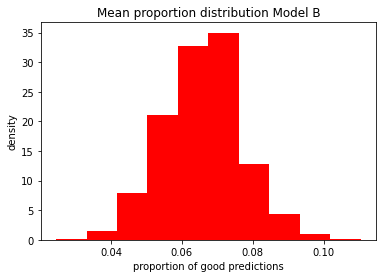

In [17]:
plt.hist(mean_prop_dist_b,density=True,color ="r")
plt.title("Mean proportion distribution Model B")
plt.xlabel("proportion of good predictions")
plt.ylabel("density")

Text(0, 0.5, 'density')

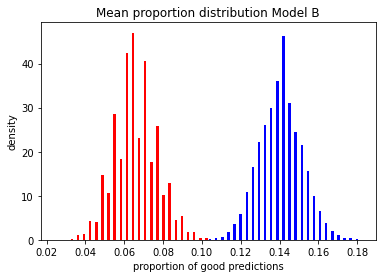

In [18]:
plt.hist([mean_prop_dist_a,mean_prop_dist_b],density=True,bins = 50, color = ["b","r"])

plt.title("Mean proportion distribution Model B")
plt.xlabel("proportion of good predictions")
plt.ylabel("density")

#### Getting Empirical distributions of the mean to build Confidence Intervals

sample = np.linspace(0,1,10000)

In [19]:
ci_a=[scipy.stats.scoreatpercentile(mean_prop_dist_a,2.5),scipy.stats.scoreatpercentile(mean_prop_dist_a,97.5)]
ci_a

[0.1196319018404908, 0.16359918200409]

In [20]:
ci_b=[scipy.stats.scoreatpercentile(mean_prop_dist_b,2.5),scipy.stats.scoreatpercentile(mean_prop_dist_b,97.5)]
ci_b

[0.044989775051124746, 0.08793456032719836]

CI Intervals do not overlap, so we reject that the average proportions are not the same in both models. 